In [98]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import os
import re

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pickle
import seaborn as sns

In [99]:
# Load the audio file
AUDIO_FILE = 'test/000002.mp3'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [100]:
Audio(AUDIO_FILE)

/var/folders/fs/bmr1lyws1dx3sp07l0gytvmc0000gn/T/ipykernel_6578/523230800.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


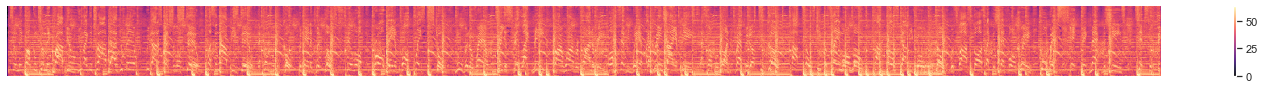

In [101]:
# Short-time Fourier transform
sgram = librosa.stft(samples)
# librosa.display.specshow(sgram)
magnitude, phase = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=magnitude, sr=sample_rate, n_mels=128, fmax=8000)

# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
mel_sgram = librosa.power_to_db(mel_scale_sgram, ref=np.min)

# Image size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = float(mel_sgram.shape[1]) / float(100)
fig_size[1] = float(mel_sgram.shape[0]) / float(100)
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')
# plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])

librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

## Load and transform all audio data

In [102]:
df = pd.read_csv('fma_metadata/tracks.csv',header=2, low_memory=False)
df.tail()

,track_id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,artist,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,genre,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,title
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN,training,large,320000,0,NaN,2017-03-30 15:23:34,NaN,162,1,Rock,[25],"[25, 12]",NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN,training,large,320000,0,NaN,2017-03-30 15:23:36,NaN,217,1,Rock,[25],"[25, 12]",NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN,training,large,320000,0,NaN,2017-03-30 15:23:37,NaN,404,2,Rock,[25],"[25, 12]",NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN,training,large,320000,0,NaN,2017-03-30 15:23:39,NaN,146,0,Rock,[25],"[25, 12]",NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths
106573,155320,0,2017-03-26 16:22:18,2017-03-26 00:00:00,NaN,1,22906,NaN,7481,NaN,"['ballad', 'epic', 'rockabilly', 'curse', 'hex...",What I Tell Myself Vol. 2,11,Album,NaN,NaN,NaN,<p>****NOTE FOR USING OUR MUSIC ON YOUTUBE****...,1,2016-02-04 17:26:24,12,21615,NaN,"Jersey City, NJ 07302",NaN,"Alishia Taiping (lead vocals, bass) \nDan Pier...",Forget the Whale,** PLEASE CONNECT WITH US THROUGH FACEBOOK! WE...,"['forget the whale', 'witches', 'rockabilly', ...",NaN,NaN,validation,large,320000,0,NaN,2017-03-30 09:15:36,NaN,198,1,NaN,"[10, 12, 169]","[169, 10, 12, 9]",NaN,972,NaN,Attribution-NonCommercial,705,NaN,7,NaN,"['ballad', 'epic', 'rockabilly', 'curse', 'hex...",Another Trick Up My Sleeve (Instrumental)


In [103]:
# # Get Genres and Track IDs from the tracks.csv file
# filename_metadata = 'fma_metadata/tracks.csv'
# tracks = pd.read_csv(filename_metadata, header=2, low_memory=False)
# tracks_array = tracks.values
# tracks_id_array = tracks_array[: , 0]
# tracks_genre_array = tracks_array[: , 40]
# tracks_id_array = tracks_id_array.reshape(tracks_id_array.shape[0], 1)
# tracks_genre_array = tracks_genre_array.reshape(tracks_genre_array.shape[0], 1)

folder_sample = 'fma_small'
directories = [d for d in os.listdir(folder_sample) if os.path.isdir(os.path.join(folder_sample, d))]

# os.makedirs('Spectogram_Images')



In [104]:
# for d in directories:
#     label_directory = os.path.join(folder_sample, d)
#     file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory) if f.endswith('.mp3')]
#     for f in file_names:
#         # track_id = int(re.search('fma_small/.*/(.+?).mp3', f).group(1))
#         # track_index = list(tracks_id_array).index(str(track_id))
        
#         # if(str(tracks_genre_array[track_index, 0]) != '0'):
#             samples, sample_rate = librosa.load(f)
#             # Short-time Fourier transform
#             sgram = librosa.stft(samples)
#             # librosa.display.specshow(sgram)
#             magnitude, phase = librosa.magphase(sgram)
#             mel_scale_sgram = librosa.feature.melspectrogram(S=magnitude, sr=sample_rate, n_mels=128, fmax=8000)
            
#             # mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
#             mel_sgram = librosa.power_to_db(mel_scale_sgram, ref=np.min)
            
#             # Image size
#             fig_size = plt.rcParams['figure.figsize']
#             fig_size[0] = float(mel_sgram.shape[1]) / float(100)
#             fig_size[1] = float(mel_sgram.shape[0]) / float(100)
#             plt.rcParams["figure.figsize"] = fig_size
#             plt.axis('off')
#             # plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])

#             librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='hz')
#             plt.savefig('Spectogram_Images/'+str(f[14:20])+'.png', bbox_inches=None, pad_inches=0) #"_"+str(tracks_genre_array[track_index,0])+
#             print(f[14:20])
#             plt.close()


In [105]:
path = '/Users/shoheisuzuki/workspace/euclidean-eukalyptus/work/music-recommendation/Spectogram_Images/'
# change the working directory to the path where the images are located
os.chdir(path)

songs = []
# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            songs.append(file.name)

In [106]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [107]:
data = {}
p = r'/Users/shoheisuzuki/workspace/euclidean-eukalyptus/work/music-recommendation/model/flower_features.pkl'

# lop through each image in the dataset
for song in songs:
    # try to extract the features and update the dictionary
    try:
        feature = extract_features(song,model)
        data[song] = feature
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

2022-03-02 11:21:02.613348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [238]:
pca = PCA(n_components=2, random_state=22) #n_components=
pca.fit(feature)
feature_new = pca.transform(feature)

In [239]:
feature_new.shape

(4834, 2)

In [240]:
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(feature_new)

KMeans(random_state=22)

In [241]:
kmeans.labels_

array([0, 4, 0, ..., 6, 1, 2], dtype=int32)

In [242]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [243]:
groups

{0: ['064629.png',
  '131166.png',
  '071230.png',
  '001066.png',
  '097986.png',
  '144937.png',
  '096695.png',
  '120309.png',
  '023172.png',
  '127499.png',
  '154305.png',
  '024423.png',
  '036999.png',
  '126220.png',
  '036966.png',
  '110779.png',
  '042017.png',
  '144472.png',
  '042016.png',
  '144473.png',
  '104725.png',
  '105413.png',
  '133638.png',
  '137462.png',
  '129884.png',
  '127498.png',
  '055436.png',
  '091312.png',
  '036146.png',
  '133016.png',
  '071225.png',
  '096696.png',
  '139934.png',
  '128811.png',
  '042376.png',
  '012390.png',
  '119979.png',
  '012179.png',
  '145747.png',
  '129879.png',
  '101893.png',
  '036959.png',
  '001893.png',
  '144470.png',
  '145752.png',
  '077521.png',
  '037111.png',
  '096898.png',
  '083715.png',
  '117160.png',
  '126430.png',
  '052389.png',
  '091329.png',
  '117170.png',
  '078038.png',
  '127266.png',
  '128814.png',
  '130929.png',
  '098655.png',
  '084485.png',
  '091088.png',
  '048931.png',
  '07

In [244]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 759 to 30


FileNotFoundError: [Errno 2] No such file or directory: '048466.png'

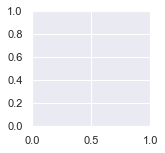

In [245]:
view_cluster(7)

In [246]:
# # this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 100))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22)
#     km.fit(feature_new)
    
#     sse.append(km.inertia_)

In [247]:
# sse

In [248]:
# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

In [249]:
df = pd.DataFrame(songs, columns=['id'])
df

,id
0,064629.png
1,127062.png
2,131166.png
3,071230.png
4,143296.png
...,...
4829,064630.png
4830,097960.png
4831,062527.png
4832,126417.png


In [250]:
df['KMeansLabels'] = kmeans.labels_

In [251]:
df

,id,KMeansLabels
0,064629.png,0
1,127062.png,4
2,131166.png,0
3,071230.png,0
4,143296.png,6
...,...,...
4829,064630.png,0
4830,097960.png,0
4831,062527.png,6
4832,126417.png,1


In [252]:
x,y = zip(*feature_new)
df['x'] = x
df['y'] = y
# df['z'] = z

In [253]:
df

,id,KMeansLabels,x,y
0,064629.png,0,16.120201,9.952659
1,127062.png,4,1.571036,-14.141870
2,131166.png,0,8.019013,3.941526
3,071230.png,0,13.884886,11.719367
4,143296.png,6,9.911375,-6.374338
...,...,...,...,...
4829,064630.png,0,16.701412,6.150576
4830,097960.png,0,9.495737,11.459825
4831,062527.png,6,20.873671,-13.713441
4832,126417.png,1,-1.095435,8.088050


In [254]:
df.set_index('KMeansLabels')

,id,x,y
KMeansLabels,,,
0,064629.png,16.120201,9.952659
4,127062.png,1.571036,-14.141870
0,131166.png,8.019013,3.941526
0,071230.png,13.884886,11.719367
6,143296.png,9.911375,-6.374338
...,...,...,...
0,064630.png,16.701412,6.150576
0,097960.png,9.495737,11.459825
6,062527.png,20.873671,-13.713441


/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Clustering by KMeans Label, Reduced Dimension')

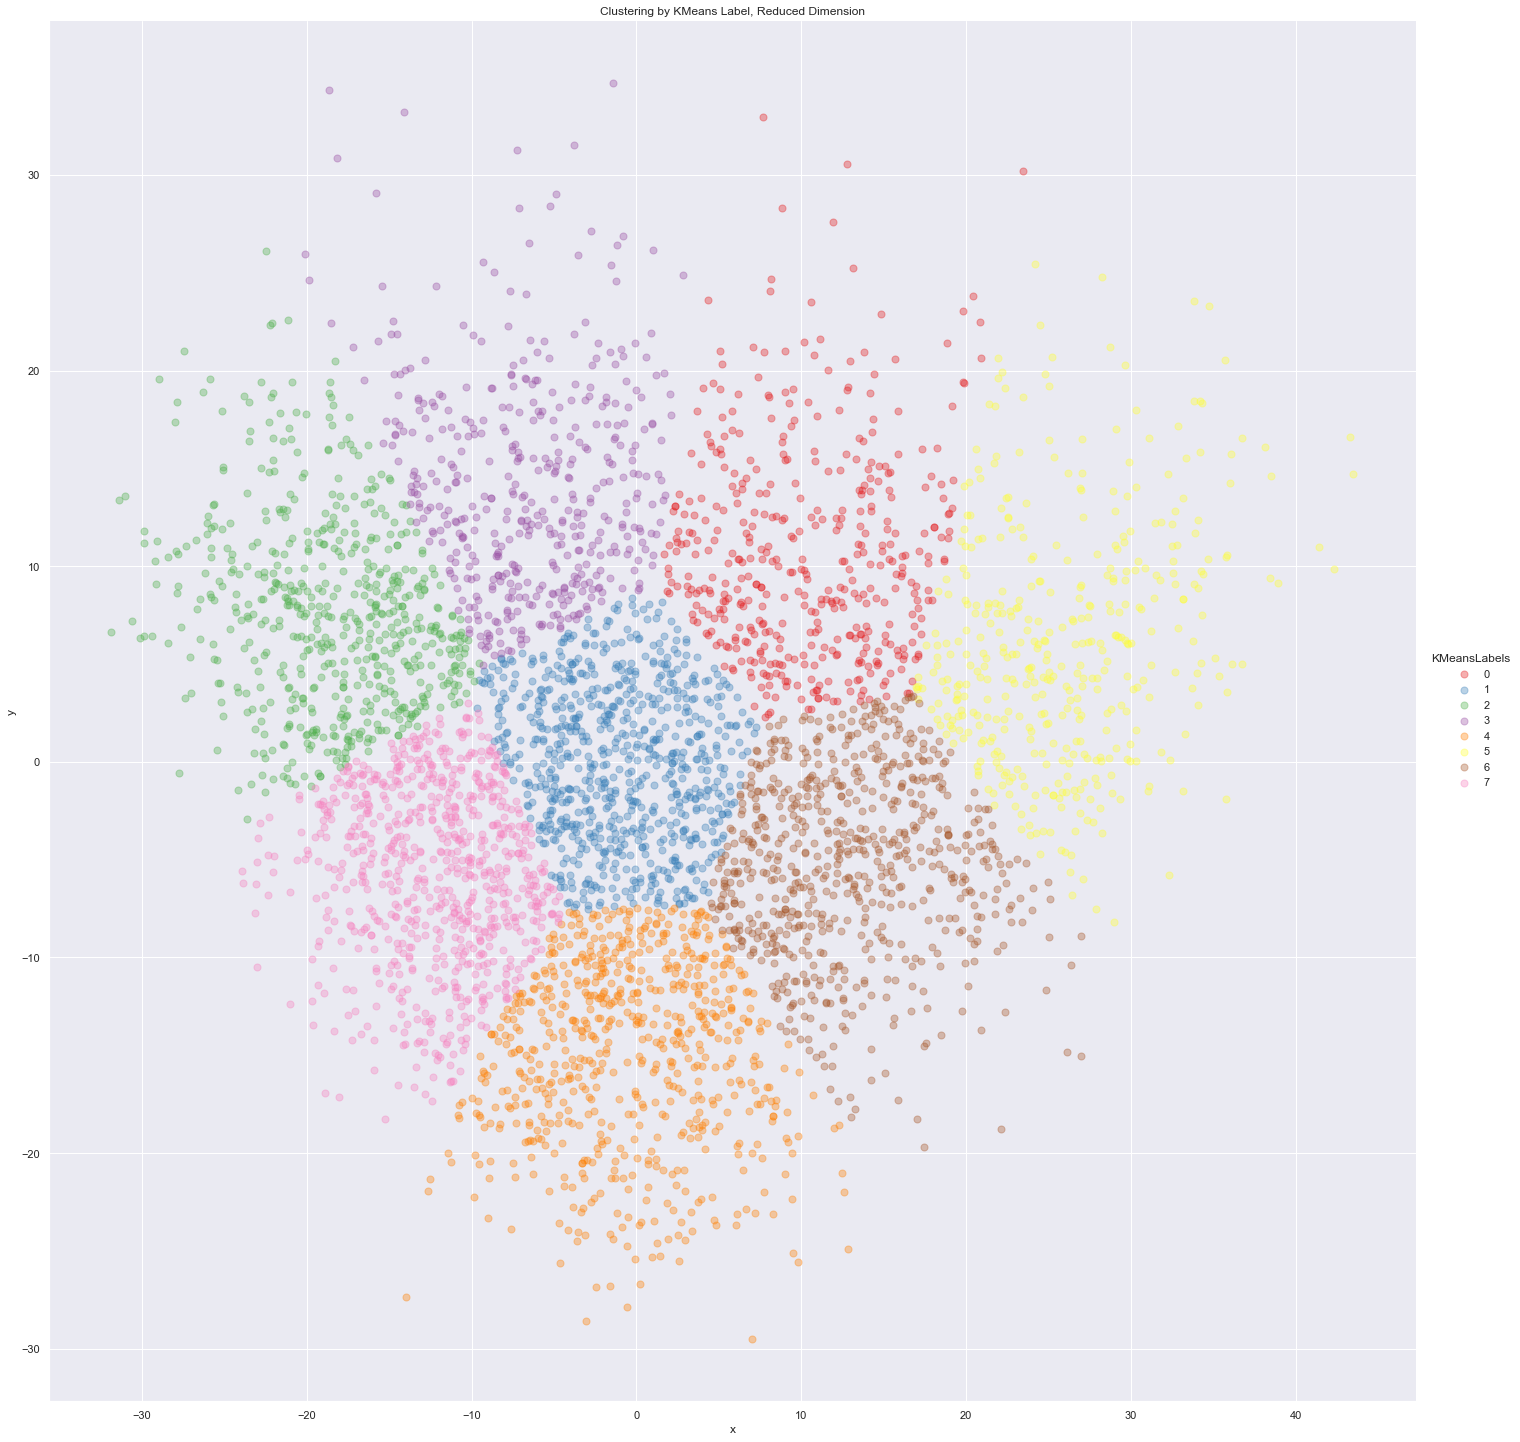

In [255]:
# sns.set(rc={'figure.figsize':(20, 20)}) #width=3, #height=4
sns.set(font_scale=1.0)

sns.lmplot(data=df, x='x', y='y', hue='KMeansLabels', fit_reg=False, legend=True, size= 20, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':50})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by KMeans Label, Reduced Dimension")

In [256]:
df.reset_index

<bound method DataFrame.reset_index of               id  KMeansLabels          x          y
0     064629.png             0  16.120201   9.952659
1     127062.png             4   1.571036 -14.141870
2     131166.png             0   8.019013   3.941526
3     071230.png             0  13.884886  11.719367
4     143296.png             6   9.911375  -6.374338
...          ...           ...        ...        ...
4829  064630.png             0  16.701412   6.150576
4830  097960.png             0   9.495737  11.459825
4831  062527.png             6  20.873671 -13.713441
4832  126417.png             1  -1.095435   8.088050
4833  139537.png             2 -21.644423   4.600641

[4834 rows x 4 columns]>

In [257]:
df['id'] = df['id'].str[:6]
df['id']

0       064629
1       127062
2       131166
3       071230
4       143296
         ...  
4829    064630
4830    097960
4831    062527
4832    126417
4833    139537
Name: id, Length: 4834, dtype: object

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4834 entries, 0 to 4833
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4834 non-null   object 
 1   KMeansLabels  4834 non-null   int32  
 2   x             4834 non-null   float32
 3   y             4834 non-null   float32
dtypes: float32(2), int32(1), object(1)
memory usage: 94.5+ KB


In [259]:
df['id'] = pd.to_numeric(df['id'])

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4834 entries, 0 to 4833
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4834 non-null   int64  
 1   KMeansLabels  4834 non-null   int32  
 2   x             4834 non-null   float32
 3   y             4834 non-null   float32
dtypes: float32(2), int32(1), int64(1)
memory usage: 94.5 KB


In [261]:
os.getcwd()

'/Users/shoheisuzuki/workspace/euclidean-eukalyptus/work/music-recommendation'

In [262]:
os.chdir('/Users/shoheisuzuki/workspace/euclidean-eukalyptus/work/music-recommendation')


In [263]:
pd.set_option('display.max_columns', None)

In [264]:
tracks = pd.read_csv('fma_metadata/tracks.csv', header=2)
tracks


,track_id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,artist,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,genre,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN,training,large,320000,0,NaN,2017-03-30 15:23:34,NaN,162,1,Rock,[25],"[25, 12]",NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DE

In [265]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   track_id  106574 non-null  int64  
 1   A         106574 non-null  int64  
 2   B         103045 non-null  object 
 3   C         70294 non-null   object 
 4   D         15295 non-null   object 
 5   E         106574 non-null  int64  
 6   F         106574 non-null  int64  
 7   G         83149 non-null   object 
 8   H         106574 non-null  int64  
 9   I         18060 non-null   object 
 10  J         106574 non-null  object 
 11  K         105549 non-null  object 
 12  L         106574 non-null  int64  
 13  M         100066 non-null  object 
 14  N         22711 non-null   object 
 15  O         5375 non-null    object 
 16  P         14271 non-null   object 
 17  Q         71156 non-null   object 
 18  R         106574 non-null  int64  
 19  S         105718 non-null  object 
 20  T   

In [266]:
tracks['track_id'].describe()

count    106574.000000
mean      79442.637435
std       44704.398384
min           2.000000
25%       40820.250000
50%       78983.500000
75%      119422.750000
max      155320.000000
Name: track_id, dtype: float64

In [267]:
df.sort_values('id',ascending=True)

,id,KMeansLabels,x,y
4632,2,6,9.574042,-8.471258
4094,5,6,12.232417,-11.515184
4015,10,7,-9.561626,-5.293013
649,140,1,6.897357,2.073364
846,141,0,6.624071,14.517472
...,...,...,...,...
4736,154308,0,13.951089,8.096651
4639,154309,0,10.152046,8.535551
1924,154413,2,-17.464449,17.620024
1273,154414,1,-0.234184,3.155380


In [268]:
df[df['id'].duplicated()]

,id,KMeansLabels,x,y


In [269]:
df['id'] = df['id'].astype(str)
df['id'] = df['id'].apply(lambda x: x.zfill(6))

In [270]:
tracks['track_id'] = tracks['track_id'].astype(str)

In [271]:
df

,id,KMeansLabels,x,y
0,064629,0,16.120201,9.952659
1,127062,4,1.571036,-14.141870
2,131166,0,8.019013,3.941526
3,071230,0,13.884886,11.719367
4,143296,6,9.911375,-6.374338
...,...,...,...,...
4829,064630,0,16.701412,6.150576
4830,097960,0,9.495737,11.459825
4831,062527,6,20.873671,-13.713441
4832,126417,1,-1.095435,8.088050


In [272]:
df.groupby('id').count()

,KMeansLabels,x,y
id,,,
000002,1,1,1
000005,1,1,1
000010,1,1,1
000140,1,1,1
000141,1,1,1
...,...,...,...
154308,1,1,1
154309,1,1,1
154413,1,1,1


In [273]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   track_id  106574 non-null  object 
 1   A         106574 non-null  int64  
 2   B         103045 non-null  object 
 3   C         70294 non-null   object 
 4   D         15295 non-null   object 
 5   E         106574 non-null  int64  
 6   F         106574 non-null  int64  
 7   G         83149 non-null   object 
 8   H         106574 non-null  int64  
 9   I         18060 non-null   object 
 10  J         106574 non-null  object 
 11  K         105549 non-null  object 
 12  L         106574 non-null  int64  
 13  M         100066 non-null  object 
 14  N         22711 non-null   object 
 15  O         5375 non-null    object 
 16  P         14271 non-null   object 
 17  Q         71156 non-null   object 
 18  R         106574 non-null  int64  
 19  S         105718 non-null  object 
 20  T   

In [274]:
tracks['track_id'] = pd.to_numeric(tracks['track_id'])
df['id'] = pd.to_numeric(df['id'])

In [275]:
df_merge = df.merge(tracks, left_on='id', right_on='track_id', how='left')
df_merge

,id,KMeansLabels,x,y,track_id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,artist,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,genre,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,title
0,64629,0,16.120201,9.952659,64629,3,2012-05-10 12:42:56,2012-03-19 00:00:00,NaN,33,11651,<p>In cities where people still laugh at the c...,207810,NaN,[],"Heavy, Crazy, Serious",9,Album,NaN,NaN,NaN,<p>In cities where people still laugh at the c...,12,2012-05-10 12:37:53,98,13493,52.406979,"Coventry, Britain",-1.507760,NaN,Blank & Kytt,NaN,['blank kytt'],http://blankkytt.bandcamp.com/,NaN,validation,small,320000,0,NaN,2012-05-10 12:44:39,NaN,65,35,Hip-Hop,[811],"[811, 21]",NaN,20918,NaN,Creative Commons Attribution,13901,NaN,5,NaN,[],Rock
1,127062,4,1.571036,-14.141870,127062,0,2015-10-31 10:24:37,2014-12-01 00:00:00,NaN,0,19206,"<p>Voici Dust, nouvel EP de Robin Mitchell. Dé...",3161,NaN,[],Dust,5,Album,NaN,NaN,NaN,"<p>Depuis 2009 le Britannique Robin Mitchell, ...",0,2013-01-03 11:39:15,4,15216,NaN,Bristol,NaN,NaN,Robin Mitchell,NaN,['robin mitchell'],http://robinmitchell.co.uk/,NaN,training,small,263988,0,NaN,2015-10-31 10:34:35,NaN,115,2,Folk,[17],[17],NaN,1324,NaN,Creative Commons Attribution-NonCommercial-NoD...,1018,NaN,1,NaN,[],When I'm Gone
2,131166,0,8.019013,3.941526,131166,0,2016-01-22 09:52:22,2014-05-02 00:00:00,Jay Kole,0,19756,NaN,18213,Matthew Luger,"['live', 'fredericksburg', 'trash rock', 'virg...",Live in Richmond: All the Hits...All the Misses,21,Album,2008-01-01 00:00:00,2016-01-01 00:00:00,NaN,"<p style=""margin:0px 0px 8px;padding:0px;font-...",0,2015-12-03 13:16:16,5,21203,NaN,"Fredericksburg, VA 22401",NaN,"Mike Tschirn: Drumbeats & Hugs\nKristin ""Monst...",The Crypts!,"Poseur Bill, Millionaire Reverends, The Points...","['garage', 'monsters', 'harmonica', 'trash roc...",http://thecrypts1.bandcamp.com/,NaN,training,small,320000,0,NaN,2016-01-22 10:53:34,NaN,165,0,Rock,"[25, 85]","[25, 12, 85]",NaN,8782,NaN,Attribution,8213,NaN,7,NaN,"['live', 'fredericksburg', 'trash rock', 'virg...",Luck That's Dumb/Happy Birthday Dave!
3,71230,0,13.884886,11.719367,71230,0,2012-10-17 07:38:45,2009-11-07 00:00:00,NaN,0,12637,"<p>""Complexo de Inferioridade"" is J-K's first ...",13846,NaN,[],Complexo de Inferioridade,8,Album,NaN,NaN,NaN,"<p>J-K was born in Africa, raised in <a href=""...",0,2012-10-17 06:54:23,7,14543,36.091091,Portugal,-18.727655,NaN,J-K,NaN,"['j-k', 'monster jinx']",http://monsterjinx.com/artista/j-k/,NaN,training,small,256000,0,NaN,2012-10-17 07:47:44,NaN,239,7,Hip-Hop,"[21, 100]","[100, 21]",NaN,5856,NaN,Attribution-NonCommercial-ShareAlike,3123,NaN,7,NaN,[],Kamikaze
4,143296,6,9.911375,-6.374338,143296,0,2016-09-19 20:01:15,NaN,NaN,0,21506,<p>Doing things with the air</p>,40191,NaN,[],The Kingdom of Back,19,Album,NaN,NaN,NaN,<p>Doing things with the air</p>,0,2016-09-19 19:57:57,1,22795,NaN,NaN,NaN,NaN,Chase Alan Willis,NaN,['chase alan willis'],https://archive.org/details/thekingdomofback,NaN,validation,small,160000,0,NaN,2016-09-19 20:02:57,NaN,178,0,Instrumental,[18],"[18, 1235]",NaN,2331,NaN,Attribution-NonCommercial-ShareAlike,2081,NaN,6,NaN,[],Cartoon Faced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,64630,0,16.701412,6.150576,64630,3,2012-05-10 12:42:56,2012-03-19 00:00:00,NaN,33,11651,<p>In cities where people still laugh at the c...,207810,NaN,[],"Heavy, Crazy, Serious",9,Album,NaN,NaN,NaN,<p>In cities where people still laugh at the c...,12,2012-05-10 12:37:53,98,13493,52.406979,"Coventry, Britain",-1.507760,NaN,Blank & Kytt,NaN,['blank kytt'],http://blankkytt.bandcamp.com/,NaN,validation,small,320000,1,NaN,2012-05-10 12:44:39,NaN,92,33,Hip-Hop,[811],"[811, 21]",NaN,18437,NaN,Creative Commons Attribution,12429,NaN,6,NaN,[],Deniro
4830,97960,0,9.495737,11.459825,97960,1,2014-01-20 21:03:14,2007-04-28 00:00:00,NaN,1,15860,"<p><a hr

In [280]:
df_merge.loc[:, ['id', 'KMeansLabels', 'x', 'y', 'artist', 'title', 'genre']]

,id,KMeansLabels,x,y,artist,title,genre
0,64629,0,16.120201,9.952659,Blank & Kytt,Rock,Hip-Hop
1,127062,4,1.571036,-14.141870,Robin Mitchell,When I'm Gone,Folk
2,131166,0,8.019013,3.941526,The Crypts!,Luck That's Dumb/Happy Birthday Dave!,Rock
3,71230,0,13.884886,11.719367,J-K,Kamikaze,Hip-Hop
4,143296,6,9.911375,-6.374338,Chase Alan Willis,Cartoon Faced,Instrumental
...,...,...,...,...,...,...,...
4829,64630,0,16.701412,6.150576,Blank & Kytt,Deniro,Hip-Hop
4830,97960,0,9.495737,11.459825,Gilo,Eu sou o fado,Electronic
4831,62527,6,20.873671,-13.713441,Tommy Tornado,Clear Vision feat. Soulmack,International
4832,126417,1,-1.095435,8.088050,Blue Dot Sessions,Tyrano Theme,Instrumental


In [ ]:
df_merge.set_index('genre')

,id,KMeansLabels,x,y,z,track_id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,artist,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,title
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Hip-Hop,64629,5,16.120197,9.952655,4.842522,64629,3,2012-05-10 12:42:56,2012-03-19 00:00:00,NaN,33,11651,<p>In cities where people still laugh at the c...,207810,NaN,[],"Heavy, Crazy, Serious",9,Album,NaN,NaN,NaN,<p>In cities where people still laugh at the c...,12,2012-05-10 12:37:53,98,13493,52.406979,"Coventry, Britain",-1.507760,NaN,Blank & Kytt,NaN,['blank kytt'],http://blankkytt.bandcamp.com/,NaN,validation,small,320000,0,NaN,2012-05-10 12:44:39,NaN,65,35,[811],"[811, 21]",NaN,20918,NaN,Creative Commons Attribution,13901,NaN,5,NaN,[],Rock
Folk,127062,2,1.571037,-14.141853,5.674106,127062,0,2015-10-31 10:24:37,2014-12-01 00:00:00,NaN,0,19206,"<p>Voici Dust, nouvel EP de Robin Mitchell. Dé...",3161,NaN,[],Dust,5,Album,NaN,NaN,NaN,"<p>Depuis 2009 le Britannique Robin Mitchell, ...",0,2013-01-03 11:39:15,4,15216,NaN,Bristol,NaN,NaN,Robin Mitchell,NaN,['robin mitchell'],http://robinmitchell.co.uk/,NaN,training,small,263988,0,NaN,2015-10-31 10:34:35,NaN,115,2,[17],[17],NaN,1324,NaN,Creative Commons Attribution-NonCommercial-NoD...,1018,NaN,1,NaN,[],When I'm Gone
Rock,131166,4,8.019011,3.941526,5.486888,131166,0,2016-01-22 09:52:22,2014-05-02 00:00:00,Jay Kole,0,19756,NaN,18213,Matthew Luger,"['live', 'fredericksburg', 'trash rock', 'virg...",Live in Richmond: All the Hits...All the Misses,21,Album,2008-01-01 00:00:00,2016-01-01 00:00:00,NaN,"<p style=""margin:0px 0px 8px;padding:0px;font-...",0,2015-12-03 13:16:16,5,21203,NaN,"Fredericksburg, VA 22401",NaN,"Mike Tschirn: Drumbeats & Hugs\nKristin ""Monst...",The Crypts!,"Poseur Bill, Millionaire Reverends, The Points...","['garage', 'monsters', 'harmonica', 'trash roc...",http://thecrypts1.bandcamp.com/,NaN,training,small,320000,0,NaN,2016-01-22 10:53:34,NaN,165,0,"[25, 85]","[25, 12, 85]",NaN,8782,NaN,Attribution,8213,NaN,7,NaN,"['live', 'fredericksburg', 'trash rock', 'virg...",Luck That's Dumb/Happy Birthday Dave!
Hip-Hop,71230,5,13.884884,11.719356,-2.482013,71230,0,2012-10-17 07:38:45,2009-11-07 00:00:00,NaN,0,12637,"<p>""Complexo de Inferioridade"" is J-K's first ...",13846,NaN,[],Complexo de Inferioridade,8,Album,NaN,NaN,NaN,"<p>J-K was born in Africa, raised in <a href=""...",0,2012-10-17 06:54:23,7,14543,36.091091,Portugal,-18.727655,NaN,J-K,NaN,"['j-k', 'monster jinx']",http://monsterjinx.com/artista/j-k/,NaN,training,small,256000,0,NaN,2012-10-17 07:47:44,NaN,239,7,"[21, 100]","[100, 21]",NaN,5856,NaN,Attribution-NonCommercial-ShareAlike,3123,NaN,7,NaN,[],Kamikaze
Instrumental,143296,1,9.911374,-6.374337,-6.980799,143296,0,2016-09-19 20:01:15,NaN,NaN,0,21506,<p>Doing things with the air</p>,40191,NaN,[],The Kingdom of Back,19,Album,NaN,NaN,NaN,<p>Doing things with the air</p>,0,2016-09-19 19:57:57,1,22795,NaN,NaN,NaN,NaN,Chase Alan Willis,NaN,['chase alan willis'],https://archive.org/details/thekingdomofback,NaN,validation,small,160000,0,NaN,2016-09-19 20:02:57,NaN,178,0,[18],"[18, 1235]",NaN,2331,NaN,Attribution-NonCommercial-ShareAlike,2081,NaN,6,NaN,[],Cartoon Faced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hip-Hop,64630,5,16.701410,6.150569,-4.318108,64630,3,2012-05-10 12:42:56,2012-03-19 00:00:00,NaN,33,11651,<p>In cities where people still laugh at the c...,207810,NaN,[],"Heavy, Crazy, Serious",9,Album,NaN,NaN,NaN,<p>In cities where people still laugh at the c...,12,2012-05-10 12:37:53,98,13493,52.406979,"Coventry, Britain",-1.507760,NaN,Blank & Kytt,NaN,['blank kytt'],http://blankkytt.bandcamp.com/,NaN,validation,small,320000,1,NaN,2012-05-10 12:44:39,NaN,92,33,[811],"[811, 21]",NaN,18437,NaN,Creative Commons Attribution,12429,NaN,6,NaN,[],Deniro


/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Clustering by KMeans Label, Reduced Dimension')

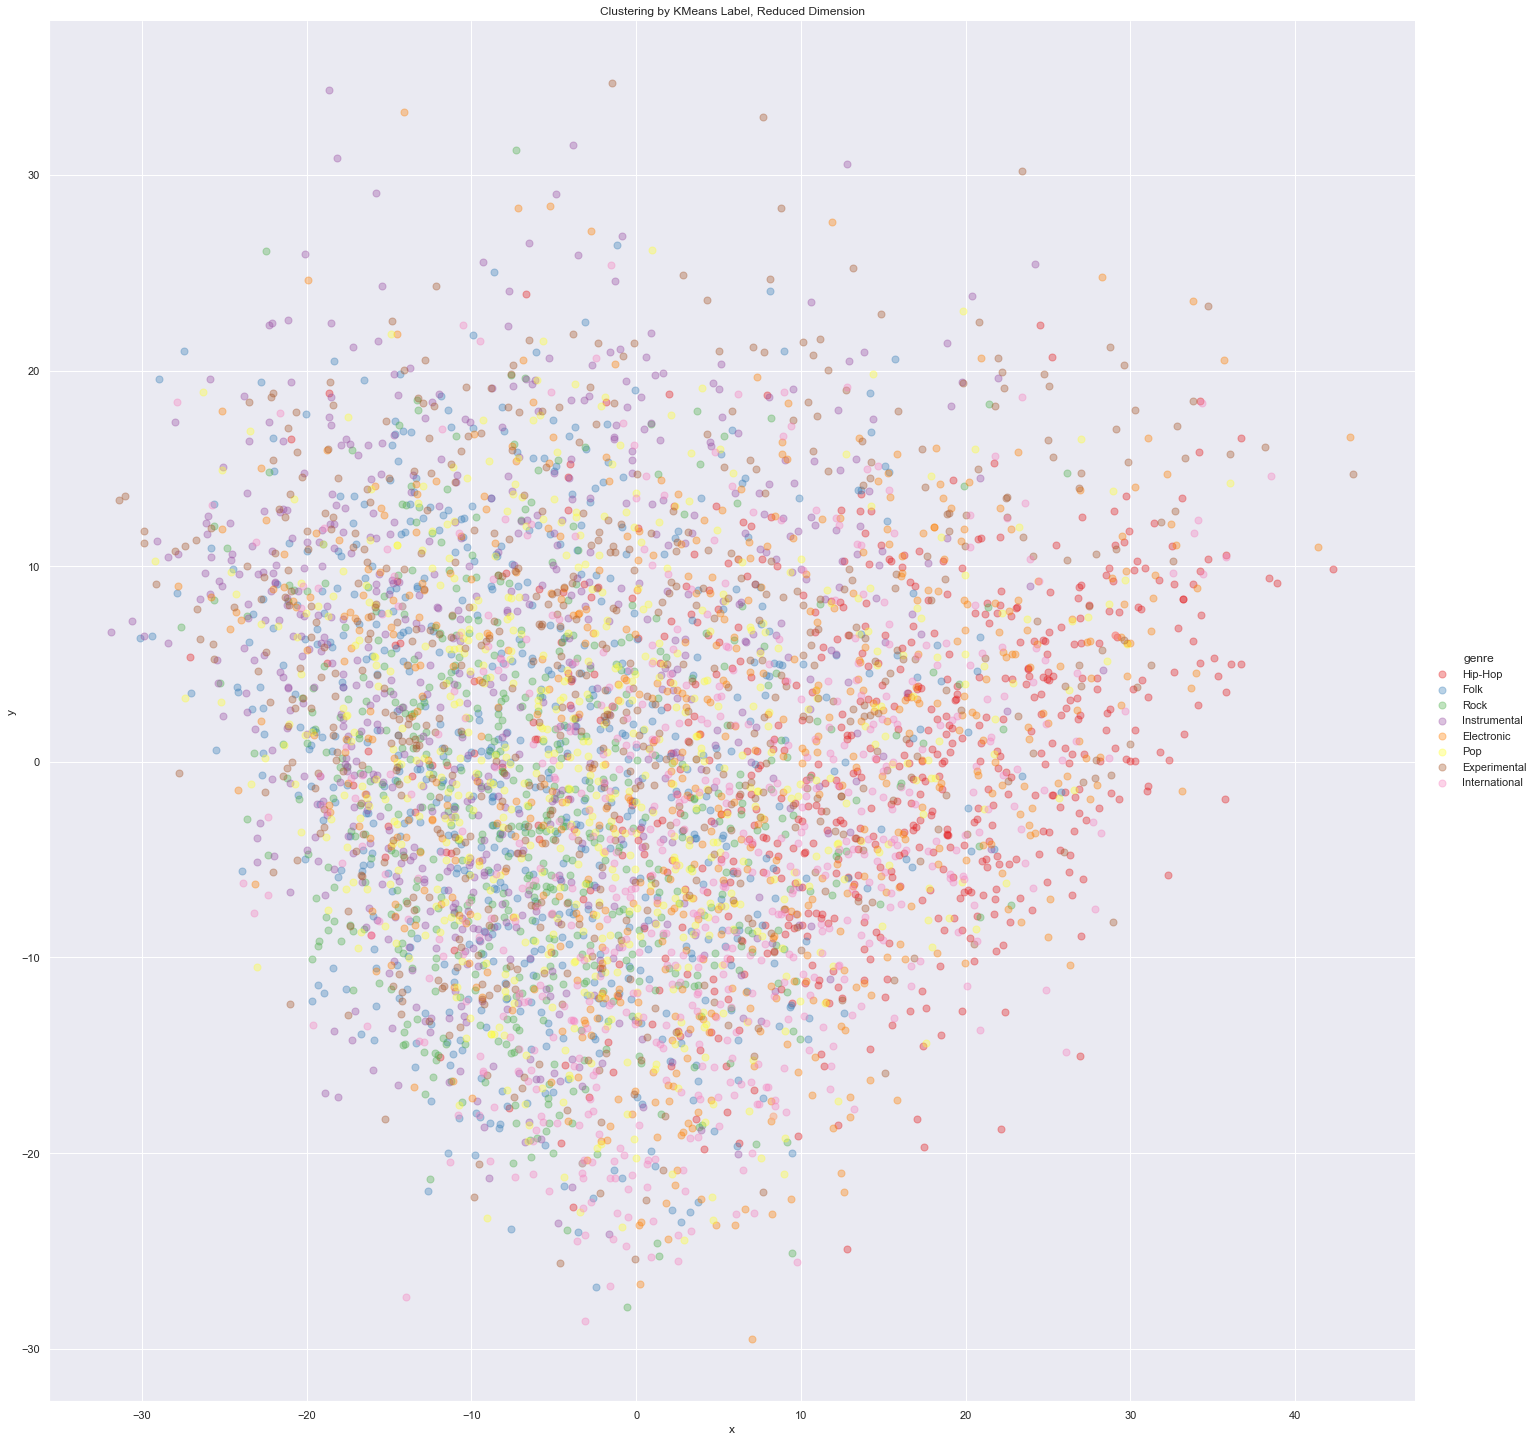

In [277]:
# sns.set(rc={'figure.figsize':(20, 20)}) #width=3, #height=4
sns.set(font_scale=1.0)

sns.lmplot(data=df_merge, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 20, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':50})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by KMeans Label, Reduced Dimension")

/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/shoheisuzuki/miniforge3/envs/music-recommendation/lib

Text(0.5, 1.0, 'Clustering by Genre Label, Reduced Dimension')

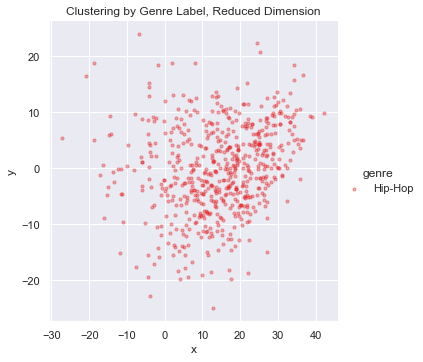

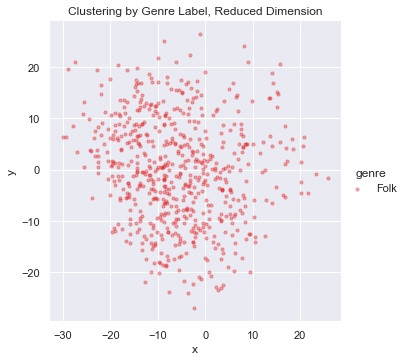

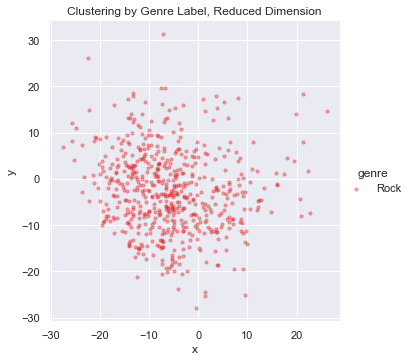

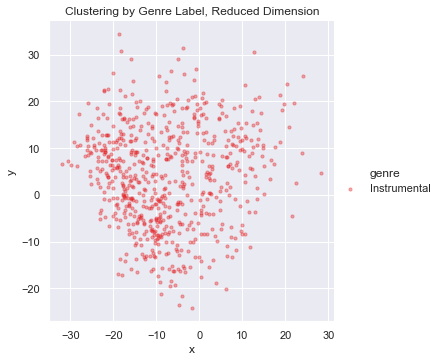

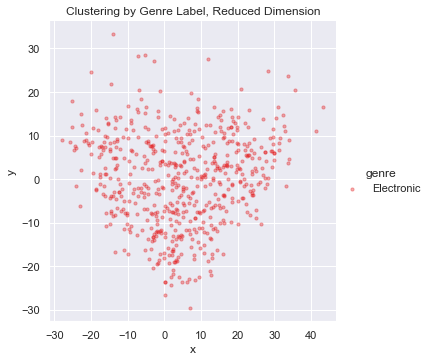

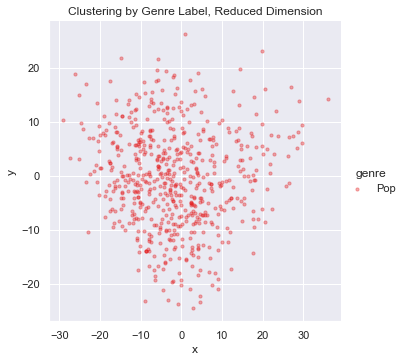

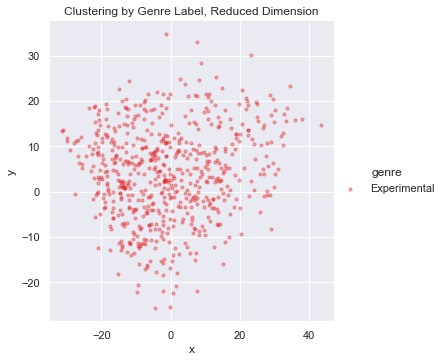

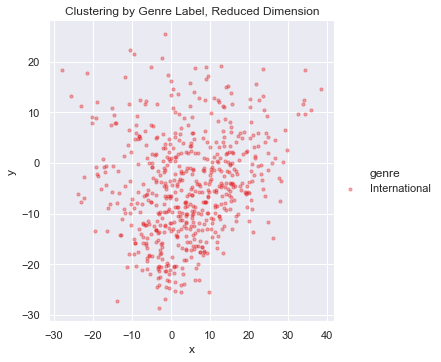

In [278]:
# sns.set(rc={'figure.figsize':(20, 20)}) #width=3, #height=4
sns.set(font_scale=1.0)

df_hiphop = df_merge.loc[df_merge['genre'] == 'Hip-Hop']
df_folk = df_merge.loc[df_merge['genre'] == 'Folk']
df_rock = df_merge.loc[df_merge['genre'] == 'Rock']
df_instrumental = df_merge.loc[df_merge['genre'] == 'Instrumental']
df_electronic = df_merge.loc[df_merge['genre'] == 'Electronic']
df_pop = df_merge.loc[df_merge['genre'] == 'Pop']
df_experimental = df_merge.loc[df_merge['genre'] == 'Experimental']
df_international = df_merge.loc[df_merge['genre'] == 'International']

sns.lmplot(data=df_hiphop, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_folk, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_rock, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_instrumental, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_electronic, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_pop, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_experimental, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

sns.lmplot(data=df_international, x='x', y='y', hue='genre', fit_reg=False, legend=True, size= 5, palette='Set1', 
    scatter_kws={'alpha':0.35, 's':10})  # lmplot # fit_reg=False, legend=True, size= 20, palette='bright', scatter_kws={'alpha':0.35, 's':25}
plt.title("Clustering by Genre Label, Reduced Dimension")

KeyError: 'z'

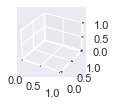

In [279]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_merge['x']
y = df_merge['y']
z = df_merge['z']

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(x, y, z)

plt.show()

In [ ]:
df_merge.groupby('genre').count()

,id,KMeansLabels,x,y,z,track_id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,artist,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,title
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Electronic,581,581,581,581,581,581,581,581,357,15,581,581,481,581,26,581,581,581,548,122,46,84,358,581,581,581,581,156,392,156,223,581,39,581,446,0,581,581,581,581,5,581,9,581,581,581,581,2,581,26,581,581,0,581,2,581,581
Experimental,617,617,617,617,617,617,617,617,421,60,617,617,507,617,102,617,617,617,602,134,15,125,398,617,617,617,617,278,394,278,225,617,60,617,441,35,617,617,617,617,28,617,63,617,617,617,617,6,617,79,617,617,0,617,12,617,617
Folk,612,612,612,612,612,612,612,612,490,188,612,612,510,612,186,612,612,612,592,145,6,111,494,612,612,612,612,153,509,153,263,612,33,612,528,45,612,612,612,612,17,612,41,612,612,612,612,3,612,111,612,612,1,612,0,612,612
Hip-Hop,592,592,592,592,592,592,592,592,482,20,592,592,477,592,56,592,592,592,585,63,20,4,507,592,592,592,592,224,422,224,229,592,25,592,537,18,592,592,592,592,1,592,5,592,592,592,592,2,592,69,592,592,2,592,0,592,592
Instrumental,659,659,659,659,659,659,659,659,410,60,659,659,584,659,78,659,659,659,622,101,29,52,506,659,659,659,659,104,390,104,241,659,49,659,539,15,659,659,659,659,19,659,26,659,659,659,659,12,659,24,659,659,0,659,8,659,659
International,593,593,593,593,593,593,593,593,420,141,593,593,514,593,153,593,593,593,559,75,14,42,481,593,593,593,593,236,419,236,350,593,28,593,469,19,593,593,593,593,25,593,59,593,593,593,593,6,593,77,593,593,1,593,0,593,593
Pop,603,603,603,603,603,603,603,603,455,65,603,603,477,603,75,603,603,603,598,68,2,26,423,603,603,603,603,248,481,248,289,603,61,603,485,14,603,603,603,603,3,603,13,603,603,603,603,4,603,54,603,603,1,603,0,603,603
Rock,577,577,577,577,577,577,577,577,381,125,577,577,442,577,153,577,577,577,556,111,34,49,457,577,577,577,577,184,477,184,320,577,63,577,494,40,577,577,577,577,19,577,30,577,577,577,577,9,577,76,577,577,10,577,2,577,577


/var/folders/fs/bmr1lyws1dx3sp07l0gytvmc0000gn/T/ipykernel_6578/34107312.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) # Method 1


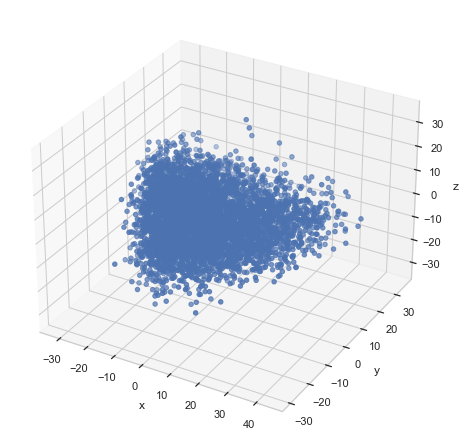

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = df_merge['x']
y = df_merge['y']
z = df_merge['z']


ax.scatter(x, y, z, marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()